In [5]:
import add_to_syspath
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import glob
from audiomnist.io.read_dataset import load_audionet_dataset
from audiomnist.train.audionet import split
from IPython.display import Audio

In [6]:
splits={"digit":{   "train":[   set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2, \
                                          8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),

                                    set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, \
                                         10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),

                                    set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41, \
                                          4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),

                                    set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42, \
                                          5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),

                                    set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1, \
                                          6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54])],

                        "validate":[set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),
                                    set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                                    set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                                    set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                                    set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55])],

                        "test":[    set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                                    set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                                    set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                                    set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),
                                    set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50])]},

            "gender":{  "train":[   set([36, 47, 56, 26, 12, 57, 2, 44, 50, 25, 37, 45]),
                                    set([26, 12, 57, 43, 28, 52, 25, 37, 45, 48, 53, 41]),
                                    set([43, 28, 52, 58, 59, 60, 48, 53, 41, 7, 23, 38]),
                                    set([58, 59, 60, 36, 47, 56, 7, 23, 38, 2, 44, 50])],

                        "validate":[set([43, 28, 52, 48, 53, 41]),
                                    set([58, 59, 60, 7, 23, 38]),
                                    set([36, 47, 56, 2, 44, 50]),
                                    set([26, 12, 57, 25, 37, 45])],

                        "test":[    set([58, 59, 60, 7, 23, 38]),
                                    set([36, 47, 56, 2, 44, 50]),
                                    set([26, 12, 57, 25, 37, 45]),
                                    set([43, 28, 52, 48, 53, 41])]}}

In [7]:
tf.enable_eager_execution()
dataset = load_audionet_dataset("../tf_data/audionet.tfrecords")

def make_tuple(record):
    return (tf.squeeze(record['data']),tf.squeeze(record['data']))

batch_size = 100

test_dataset = dataset.filter(split('digit', 'test')) \
    .map(make_tuple) \
    .shuffle(10000, seed=42) \
    .batch(batch_size)

test_nb_samples = len(splits['digit']['test'][0])*500

In [12]:
input_img= Input(shape=(8000,1))

encoded = Conv1D(filters = 16,kernel_size = 4,activation = 'relu',padding ='same')(input_img)
encoded = MaxPooling1D(pool_size =  4)(encoded)
encoded = Conv1D(filters = 8,kernel_size = 4,activation = 'relu',padding ='same')(encoded)
encoded = MaxPooling1D(pool_size =  4)(encoded)
encoded = Conv1D(filters = 8,kernel_size = 4,activation = 'relu',padding ='same')(encoded)
encoded = MaxPooling1D(pool_size =  4)(encoded)

decoded = Conv1D(filters = 8,kernel_size = 4,activation = 'relu',padding ='same')(encoded)
decoded = UpSampling1D(size = 4)(decoded)
decoded = Conv1D(filters = 8,kernel_size = 4,activation = 'relu',padding ='same')(decoded)
decoded = UpSampling1D(size = 4)(decoded)
decoded = Conv1D(filters = 16,kernel_size = 4,activation = 'relu',padding ='same')(decoded)
decoded = UpSampling1D(size = 4)(decoded)
decoded = Conv1D(filters = 1,kernel_size = 4,activation = 'linear',padding ='same')(decoded)


autoencoder=Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 8000, 16)          80        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2000, 16)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 2000, 8)           520       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 500, 8)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 500, 8)            264       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 125, 8)            0         
__________

In [10]:
def get_epoch_checkpoint(checkpoint_path, epoch):
    epoch_checkpoint = glob.glob(os.path.join(checkpoint_path, f"model.{epoch}-*.data*"))
    print(epoch_checkpoint)
    assert len(epoch_checkpoint) == 1
    epoch_checkpoint = epoch_checkpoint[0].split(".data")[0]
    return epoch_checkpoint


checkpoint_path = "../models/autoencConv"
epoch_checkpoint = get_epoch_checkpoint(checkpoint_path, 10)
autoencoder.load_weights(epoch_checkpoint)

['../models/autoencConv/model.10-0.34.data-00000-of-00001']


In [12]:
for e in test_dataset:pass

ini = tf.reshape(e[0][15],[1,8000,1])
after = autoencoder.predict(ini, steps = 1)

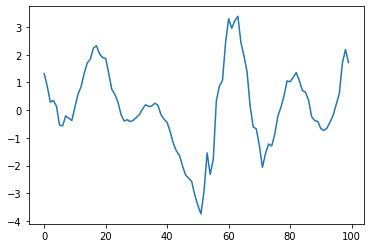

In [15]:
plt.plot(np.array(ini).flatten()[5000:5100])
plt.show()

Audio(np.array(ini).flatten(),rate = 8000)

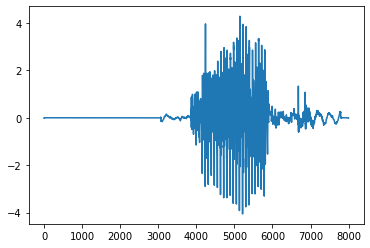

In [14]:
plt.plot(np.array(after).flatten())
plt.show()

Audio(np.array(after).flatten(),rate = 8000)